# Potato Disease Classification

# Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
path= '/content/drive/MyDrive/Potato_Disease'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2153 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight']

In [ ]:
len(dataset)

68

In [ ]:
68*32

2176

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 2 2 0 0 0 0 0 2 2 2 2 0 2 0 2 2 2 0 2 0 2 0 0 2 0 0 1 2 2 0 0]


Visualizing Some Images from the Dataset

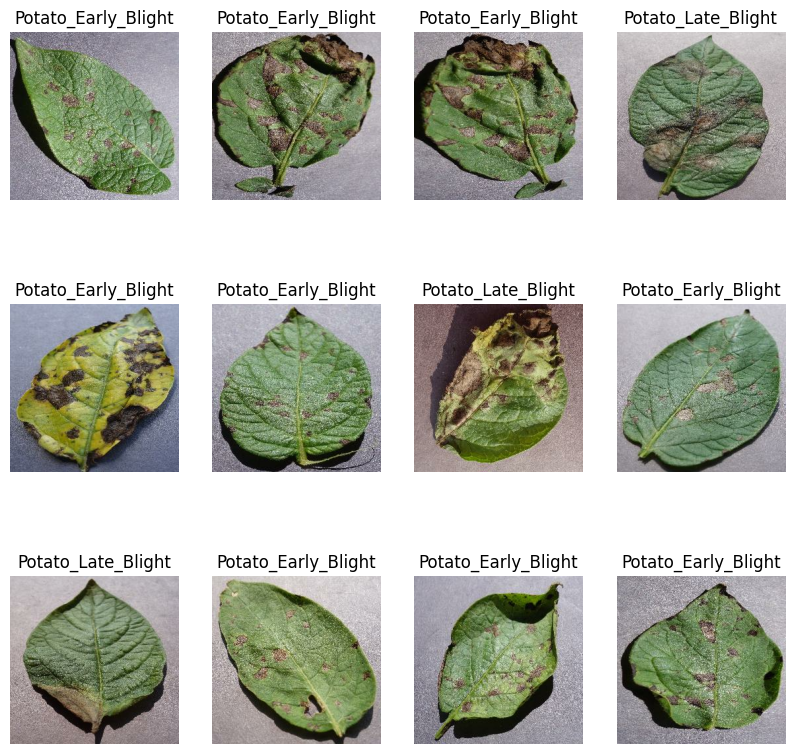

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax= plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

#Splitting the Dataset
1. Training: Dataset to be used while training
2. Validation: Dataset should be tested against while Training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

68

In [ ]:
train_size= 0.8 #80%
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size= 0.1
len(dataset)*val_size #Approx equal to 7

6.800000000000001

In [ ]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [ ]:
test_ds = test_ds.skip(7)
len(test_ds)

7

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds), len(test_ds), len(val_ds)

(54, 8, 6)

## Cache, Shuffle and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Resizing & Normalization
* Input can supply an image that is not (256,256) and this layer will resize it
*  To improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation
* Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

In [ ]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),   #adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
    metrics=['accuracy']
)

In [ ]:
history= model.fit(
    train_ds,
    batch_size= BATCH_SIZE,
    validation_data= val_ds,
    verbose= 1,
    epochs= 30,
)

Epoch 1/30
54/54 [==============================] - 540s 5s/step - loss: 0.8941 - accuracy: 0.4797 - val_loss: 0.8414 - val_accuracy: 0.6250
Epoch 2/30
54/54 [==============================] - 271s 5s/step - loss: 0.6014 - accuracy: 0.7130 - val_loss: 0.5678 - val_accuracy: 0.7292
Epoch 3/30
54/54 [==============================] - 281s 5s/step - loss: 0.3822 - accuracy: 0.8368 - val_loss: 0.2851 - val_accuracy: 0.8854
Epoch 4/30
54/54 [==============================] - 270s 5s/step - loss: 0.2688 - accuracy: 0.8941 - val_loss: 0.2351 - val_accuracy: 0.9167
Epoch 5/30
54/54 [==============================] - 271s 5s/step - loss: 0.2096 - accuracy: 0.9207 - val_loss: 0.1499 - val_accuracy: 0.9479
Epoch 6/30
54/54 [==============================] - 271s 5s/step - loss: 0.2256 - accuracy: 0.9051 - val_loss: 0.2267 - val_accuracy: 0.9375
Epoch 7/30
54/54 [==============================] - 267s 5s/step - loss: 0.1498 - accuracy: 0.9392 - val_loss: 0.1157 - val_accuracy: 0.9479
Epoch 8/30
54

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 20s 1s/step - loss: 0.0149 - accuracy: 0.9961


In [ ]:
scores

[0.01490581315010786, 0.99609375]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [ ]:
type(history.history['loss'])

list

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

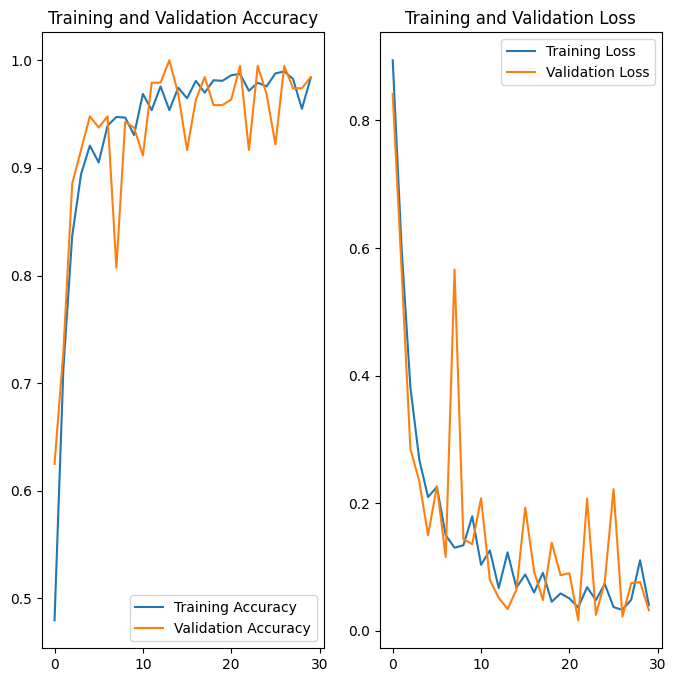

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Running Predictions on a Sample Image

first image to predict
actual label: [2]
1/1 [==============================] - 1s 1s/step
predicted label: [2]


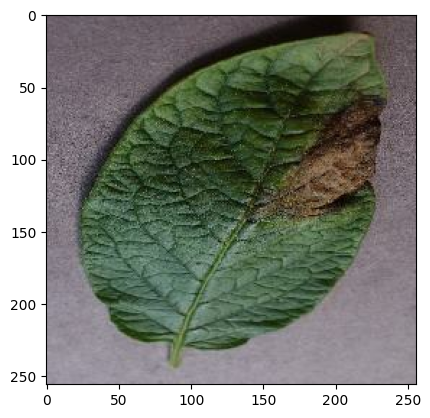

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",[np.argmax(batch_prediction[0])])

first image to predict
actual label: Potato_Late_Blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato_Late_Blight


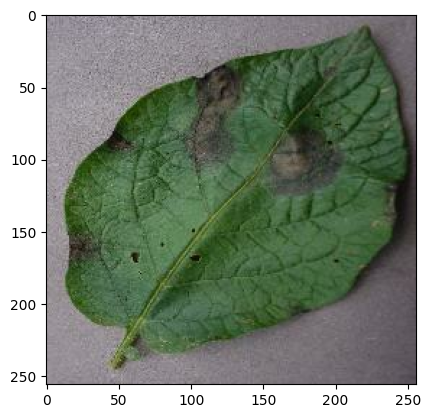

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Potato_Early_Blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato_Early_Blight


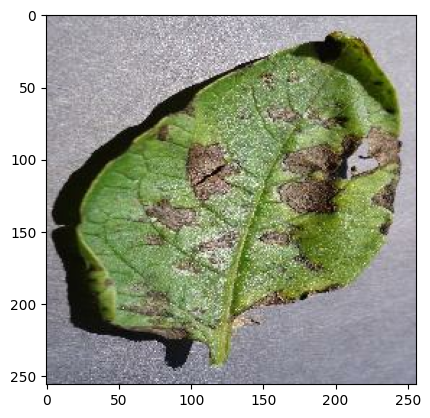

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[3].numpy().astype('uint8')
    first_label = labels_batch[3].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[3])])

## Calculating the **Confidence Score**

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 240ms/step


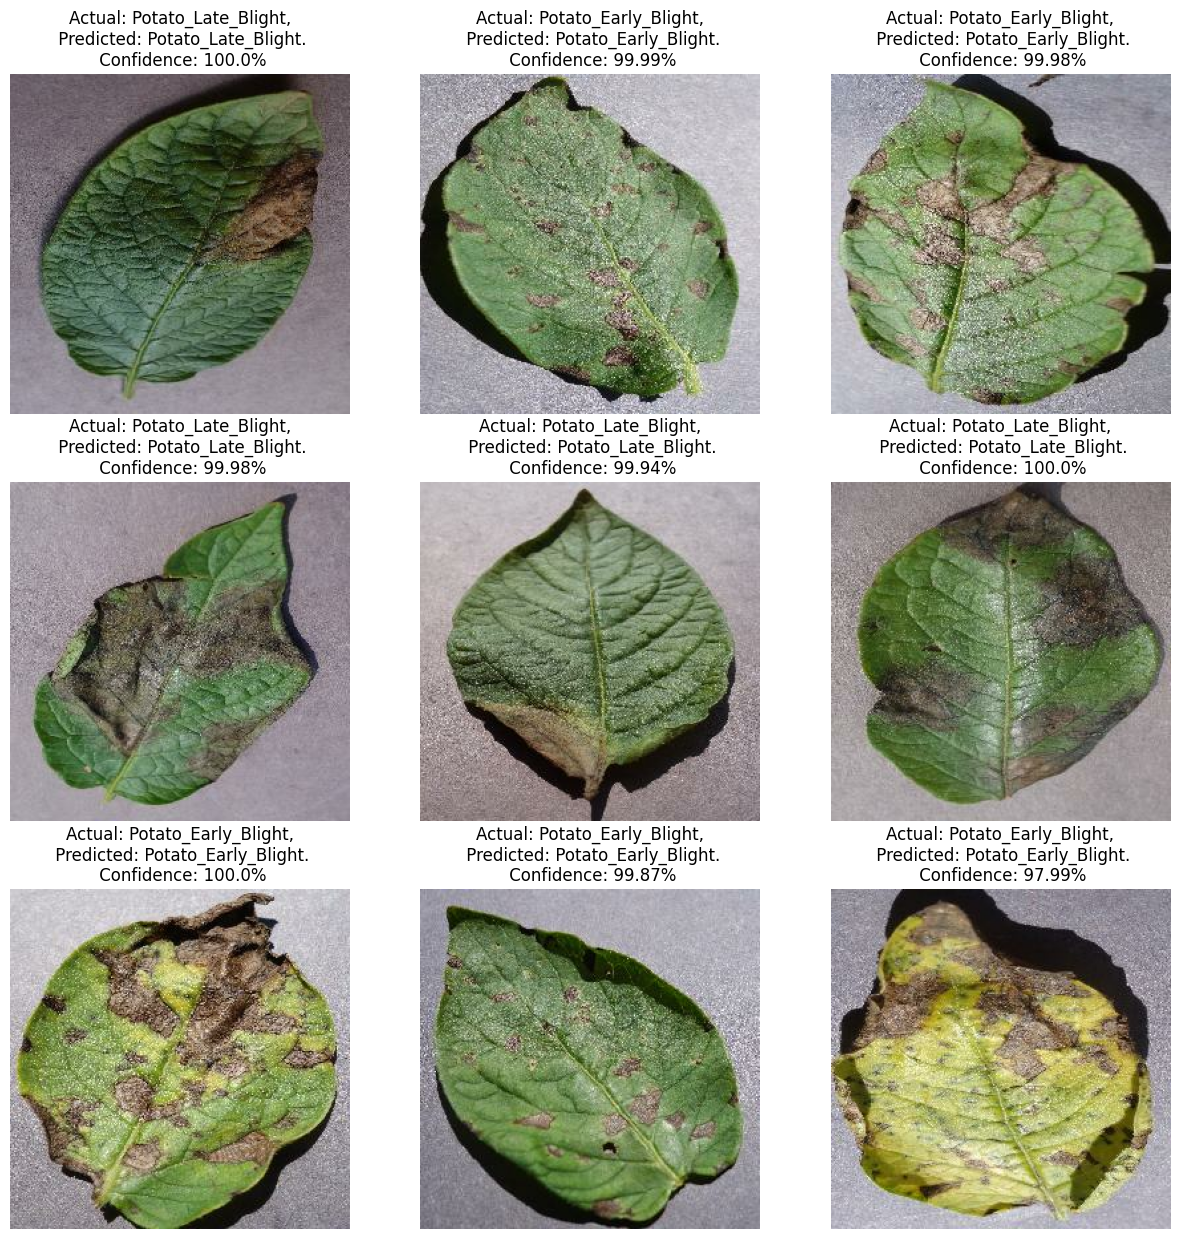

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Saving the Model

In [ ]:
dir = '/content/drive/MyDrive/Potato_Disease'

In [ ]:
model.save('Tensorflow.h5')